Cluster 0 平均 FPS: 59.83
Cluster 1 平均 FPS: 56.60

聚类与人工标签的重合度:
准确率: 0.5078

分类报告:
              precision    recall  f1-score   support

           0       0.73      0.49      0.58      1500
           1       0.31      0.56      0.40       609

    accuracy                           0.51      2109
   macro avg       0.52      0.52      0.49      2109
weighted avg       0.61      0.51      0.53      2109



正常(标签0)的预测准确率: 0.4873
异常(标签1)的预测准确率: 0.5583


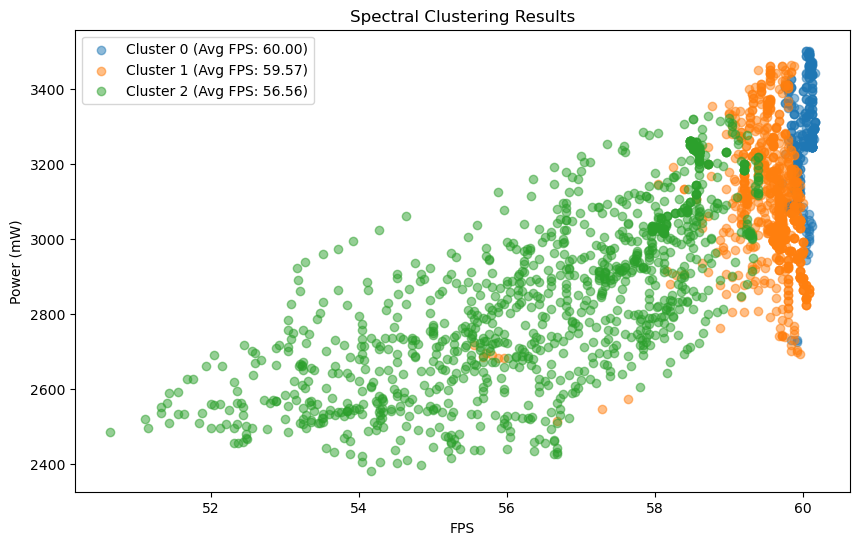

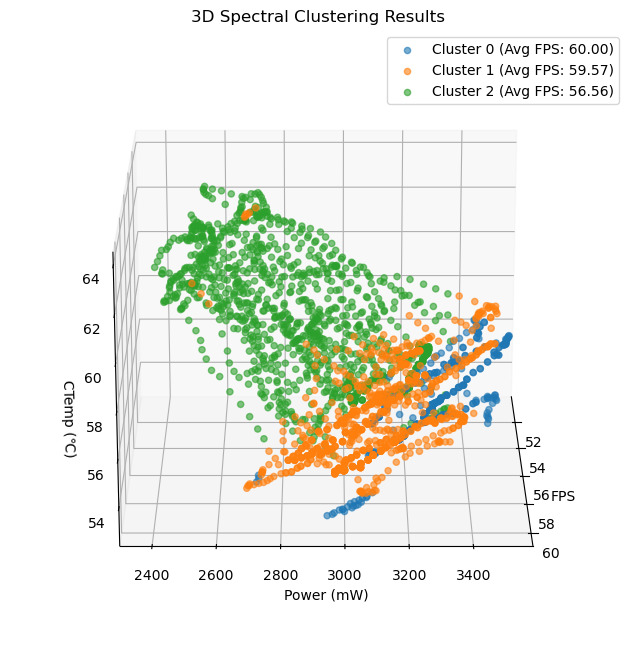

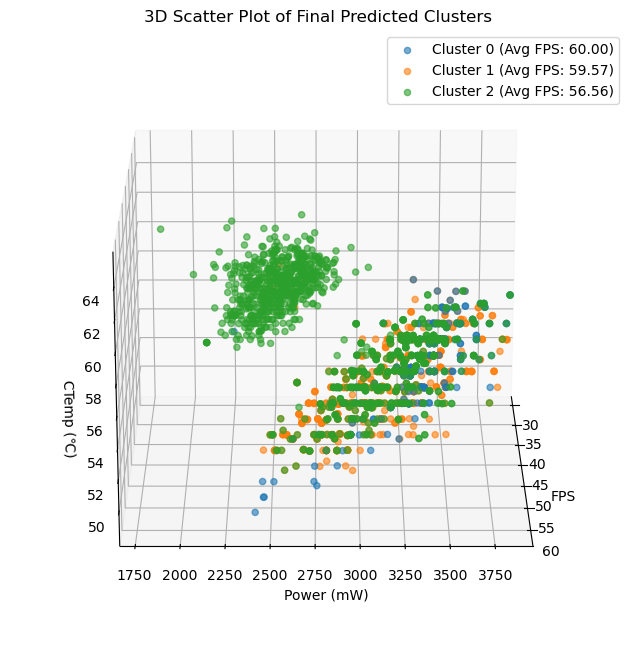

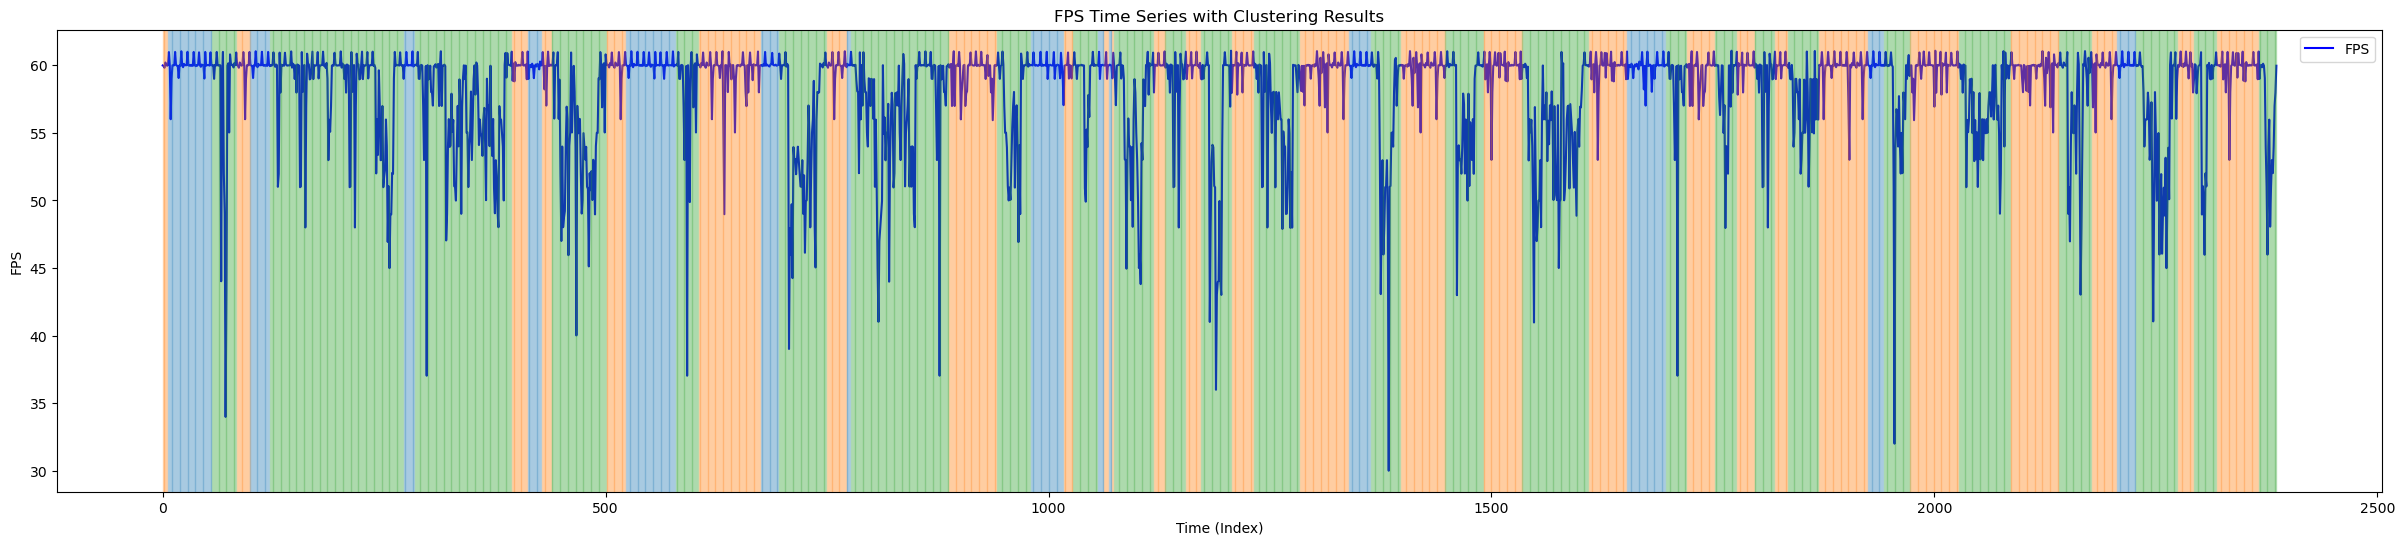

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.cluster import SpectralClustering
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_test = pd.read_csv("test.csv")
df_label = pd.read_csv("test_label.csv")
fps_data = df_test['FPS'].values
human_labels = df_label['label'].values

# 构建频谱
window_size = 25
frequencies = []
for i in range(len(fps_data) - window_size + 1):  # 修改：步长改为1
    segment = fps_data[i:i + window_size]
    freq, power = welch(segment, nperseg=window_size)
    frequencies.append(power)

frequencies = np.array(frequencies)

# 谱聚类
# n_clusters = 2
# human_lable_mapping = {0:0, 1:1}  # clasuter -> human label mapping
n_clusters = 3
human_lable_mapping = {0:0, 1:0, 2:1}  # clasuter -> human label mapping
# n_clusters = 4
# human_lable_mapping = {0:0, 1:0, 2:0, 3:1}  # clasuter -> human label mapping

clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=535)
labels = clustering.fit_predict(frequencies)

# 根据聚类结果计算平均 FPS 并命名
cluster_names = {}
cluster_avg_fps = np.zeros(n_clusters)
for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    mid_fps = np.mean([np.mean(fps_data[i:i + window_size]) for i in cluster_indices])  # 修改：使用窗口起始位置i
    cluster_names[cluster] = f"Cluster {cluster} (Avg FPS: {mid_fps:.2f})"
    cluster_avg_fps[cluster] = mid_fps

# 根据平均 FPS 对聚类结果进行排序
# 根据平均 FPS 对聚类结果进行排序（从高到低）
sorted_clusters = sorted(range(n_clusters), key=lambda x: cluster_avg_fps[x], reverse=True)

# 重新映射聚类标签
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
labels = np.array([label_mapping[label] for label in labels])

# 更新聚类名称和平均FPS
sorted_cluster_names = {}
sorted_cluster_avg_fps = np.zeros(n_clusters)
for new_idx, old_idx in enumerate(sorted_clusters):
    sorted_cluster_names[new_idx] = f"Cluster {new_idx} (Avg FPS: {cluster_avg_fps[old_idx]:.2f})"
    sorted_cluster_avg_fps[new_idx] = cluster_avg_fps[old_idx]

cluster_names = sorted_cluster_names
cluster_avg_fps = sorted_cluster_avg_fps



# 结果分析
# 计算聚类与human_labels的重合度
# 首先需要将窗口级别的聚类标签映射回原始时间序列
predicted_labels = np.zeros(len(fps_data))

# 将聚类结果映射到原始时间序列
for i in range(len(labels)):
    start_idx = i
    end_idx = i + window_size
    predicted_labels[start_idx:end_idx] = labels[i]

# 由于窗口重叠，取众数作为最终预测
final_predicted = np.zeros(len(fps_data))
for i in range(len(fps_data)):
    # 找到覆盖当前时间点的所有窗口
    covering_windows = []
    for j in range(max(0, i - window_size + 1), min(len(labels), i + 1)):
        if j + window_size > i:
            covering_windows.append(labels[j])
    
    if covering_windows:
        # 取众数
        final_predicted[i] = Counter(covering_windows).most_common(1)[0][0]

report = True
if report:

    mapped_predicted = [human_lable_mapping[int(label)] for label in final_predicted]
    # 确定聚类标签对应关系
    # 计算每个聚类对应的平均FPS
    cluster_0_fps = np.mean([fps_data[i] for i in range(len(fps_data)) if mapped_predicted[i] == 0])
    cluster_1_fps = np.mean([fps_data[i] for i in range(len(fps_data)) if mapped_predicted[i] == 1])

    print(f"Cluster 0 平均 FPS: {cluster_0_fps:.2f}")
    print(f"Cluster 1 平均 FPS: {cluster_1_fps:.2f}")

    # 需要从df_label中获取对应的标签
    human_labels_array = df_label['label'].values

    # 确保长度一致
    min_len = min(len(mapped_predicted), len(human_labels_array))
    mapped_predicted_trimmed = mapped_predicted[:min_len]
    human_labels_trimmed = human_labels_array[:min_len]

    accuracy = accuracy_score(human_labels_trimmed, mapped_predicted_trimmed)
    conf_matrix = confusion_matrix(human_labels_trimmed, mapped_predicted_trimmed)

    print(f"\n聚类与人工标签的重合度:")
    print(f"准确率: {accuracy:.4f}")
    # print(f"混淆矩阵:")
    # print(conf_matrix)
    print(f"\n分类报告:")
    print(classification_report(human_labels_trimmed, mapped_predicted_trimmed))

    # 计算每个类别的准确率
    print(f"\n")
    print(f"正常(标签0)的预测准确率: {conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]):.4f}")
    print(f"异常(标签1)的预测准确率: {conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]):.4f}")


# 可视化聚类结果
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    compute_fps = lambda i: fps_data[i:i + window_size].mean()
    compute_power = lambda i: df_test['Power[mW]'].iloc[i:i + window_size].mean()
    compute_ctemper = lambda i: df_test['CTemp[℃]'].iloc[i:i + window_size].mean()
    cluster_points = [(compute_fps(i), compute_power(i))for i in cluster_indices]
    cluster_points = np.array(cluster_points)
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_names[cluster],alpha=0.5)

plt.xlabel('FPS')
plt.ylabel('Power (mW)')
plt.title('Spectral Clustering Results')
plt.legend()
plt.savefig('spectral_clustering_results.png')


# 可视化聚类结果 - 三维散点图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    compute_fps = lambda i: fps_data[i:i + window_size].mean()
    compute_power = lambda i: df_test['Power[mW]'].iloc[i:i + window_size].mean()
    compute_ctemper = lambda i: df_test['CTemp[℃]'].iloc[i:i + window_size].mean()
    
    cluster_points = [(compute_fps(i), compute_power(i), compute_ctemper(i)) for i in cluster_indices]
    cluster_points = np.array(cluster_points)
    
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
               label=cluster_names[cluster], alpha=0.6, s=20)

ax.set_xlabel('FPS')
ax.set_ylabel('Power (mW)')
ax.set_zlabel('CTemp (℃)')
ax.set_title('3D Spectral Clustering Results')
# 调整视角以获得更好的可视化效果
ax.view_init(elev=20, azim=0)
ax.legend()
plt.savefig('spectral_clustering_3d_results.png', dpi=300, bbox_inches='tight')

# 可视化 final_predicted 和原始数据点的三维散点图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 为每个聚类绘制散点图
for cluster in range(n_clusters):
    cluster_mask = final_predicted == cluster
    ax.scatter(df_test.loc[cluster_mask, 'FPS'], 
               df_test.loc[cluster_mask, 'Power[mW]'], 
               df_test.loc[cluster_mask, 'CTemp[℃]'],
               c=f'C{cluster}', 
               label=cluster_names[cluster], 
               alpha=0.6, 
               s=20)

ax.set_xlabel('FPS')
ax.set_ylabel('Power (mW)')
ax.set_zlabel('CTemp (℃)')
ax.set_title('3D Scatter Plot of Final Predicted Clusters')
ax.legend()
ax.view_init(elev=20, azim=0)
plt.savefig('final_predicted_3d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# 绘制 FPS 时序图并显示聚类结果
plt.figure(figsize=(30, 6))
plt.plot(fps_data, label='FPS', color='blue')

# 根据final_predicted添加聚类结果的着色
for i in range(len(final_predicted)):
    if final_predicted[i] == -1: continue
    color = f'C{int(final_predicted[i])}'
    plt.axvline(x=i, color=color, alpha=0.3, linewidth=1)

# 添加图例
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=f'C{cluster}', alpha=0.3, label=cluster_names[cluster]) 
                   for cluster in range(n_clusters)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Time (Index)')
plt.ylabel('FPS')
plt.title('FPS Time Series with Clustering Results')
plt.legend()
plt.savefig('fps_time_series_with_clustering.png')


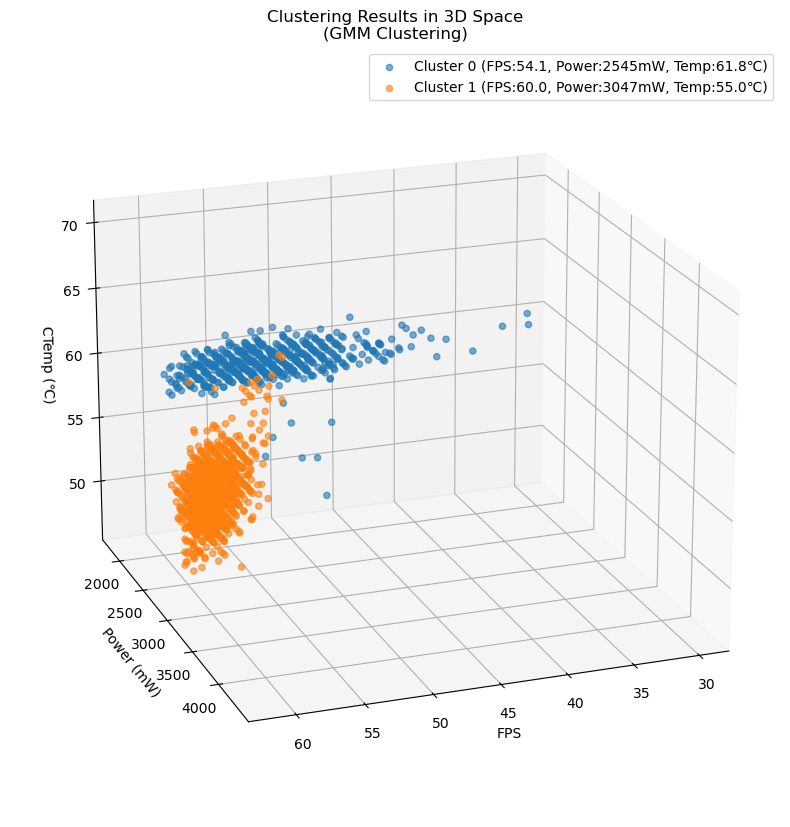

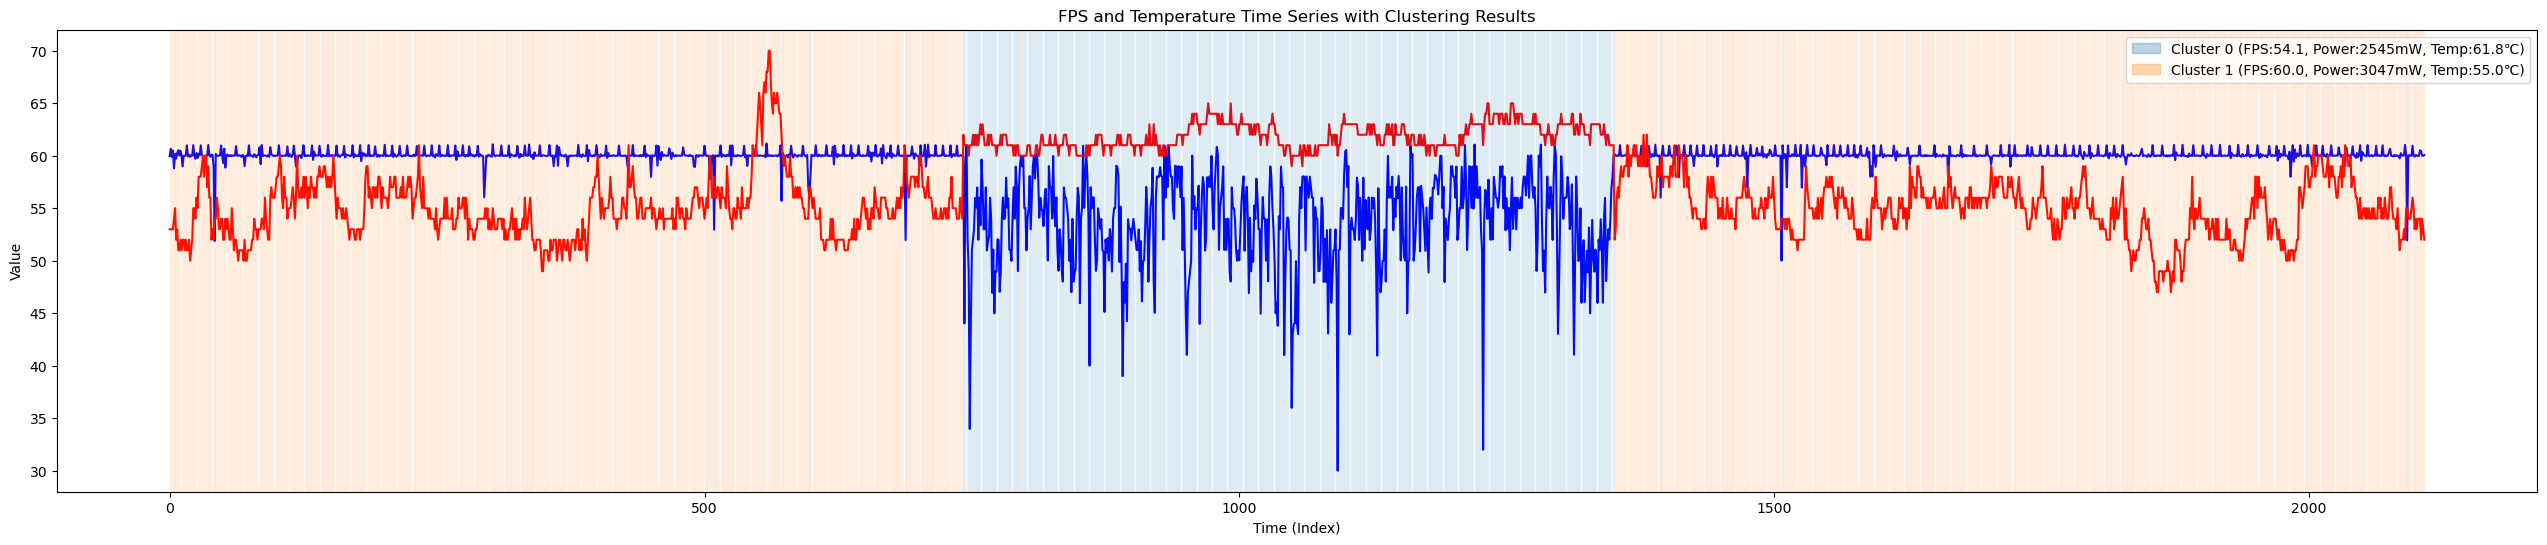

聚类结果统计:
Cluster 0 (FPS:54.1, Power:2545mW, Temp:61.8℃): 616个样本 (29.2%)
Cluster 1 (FPS:60.0, Power:3047mW, Temp:55.0℃): 1493个样本 (70.8%)

GMM聚类与人工标签的重合度分析:
准确率: 0.3269
混淆矩阵:
[[ 401 1174]
 [ 214  273]]

分类报告:
              precision    recall  f1-score   support

           0       0.65      0.25      0.37      1575
           1       0.19      0.56      0.28       487

    accuracy                           0.33      2062
   macro avg       0.42      0.41      0.32      2062
weighted avg       0.54      0.33      0.35      2062


详细分析:
正常(标签0)的预测准确率: 0.2546
异常(标签1)的预测准确率: 0.5606

聚类标签分布:
Cluster 0: {0: 401, 1: 214} (主要标签: 0)
Cluster 1: {0: 1174, 1: 273} (主要标签: 0)
分类器训练结果:
分类器准确率: 0.9984

分类报告:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       1.00      1.00      1.00       467

    accuracy                           1.00       633
   macro avg       1.00      1.00      1.00       633
weighted avg       1.00    

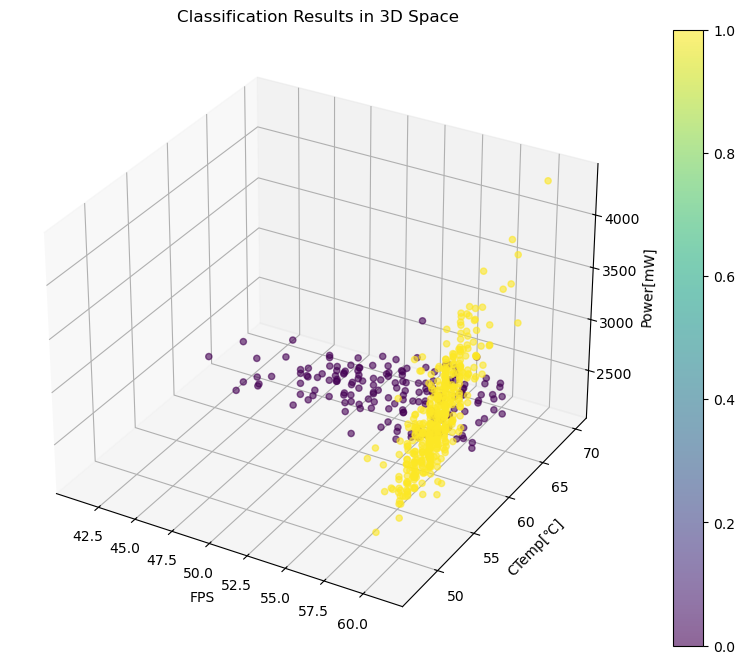

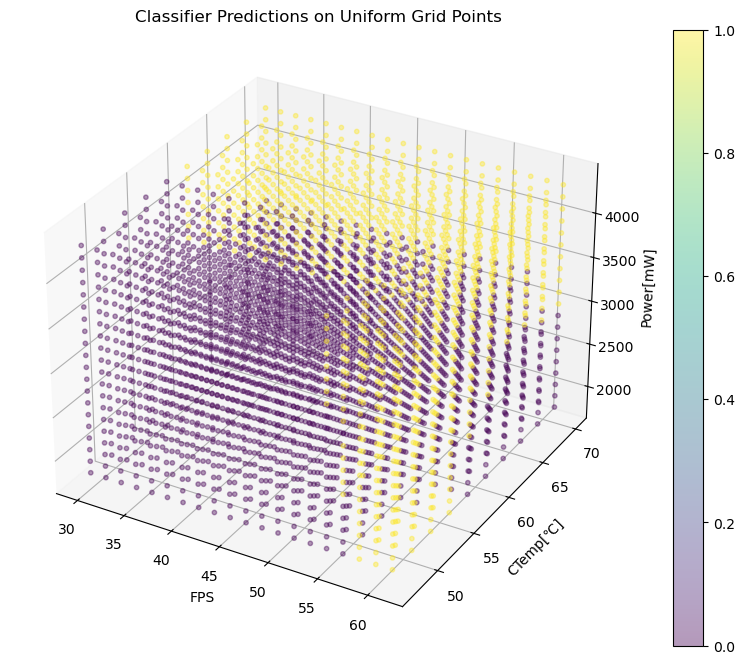

分类器已保存到: clustering_model.pkl


In [37]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import joblib
import os
from scipy import signal
from scipy.fft import fft, fftfreq
from itertools import product
from mpl_toolkits.mplot3d import Axes3D

def load_data(test_file, label_file=None):
    """
    Load test data and optional label data
    
    Args:
        test_file (str): Path to test data CSV file
        label_file (str, optional): Path to label data CSV file
    
    Returns:
        tuple: (df_test, df_label) where df_label is None if not provided
    """
    df_test = pd.read_csv(test_file)
    df_label = None
    if label_file and os.path.exists(label_file):
        df_label = pd.read_csv(label_file)
    return df_test, df_label

def preprocess_features(df_test, exclude_columns=['absTime']):
    """
    Preprocess features by handling missing values and standardization
    
    Args:
        df_test (pd.DataFrame): Test data
        exclude_columns (list): Columns to exclude from features
    
    Returns:
        tuple: (features_scaled, scaler, feature_columns)
    """
    # Extract features excluding specified columns
    feature_columns = df_test.columns.difference(exclude_columns)
    features_data = df_test[feature_columns].values
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    features_data = imputer.fit_transform(features_data)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_data)
    
    return features_scaled, scaler, feature_columns

def spectral_clustering_sliding_window(features_scaled, n_clusters=2, window_size=25, step_size=1, vote_threshold=0.5, random_state=42):
    """
    Perform spectral clustering using a sliding window approach.
    Each data point is assigned a cluster label by majority voting from overlapping windows.

    Args:
        features_scaled (np.array): Scaled features
        n_clusters (int): Number of clusters
        window_size (int): Size of the sliding window
        step_size (int): Step size for sliding window
        vote_threshold (float): Minimum fraction of votes to assign a label (default 0.5)
        random_state (int): Random state for reproducibility

    Returns:
        tuple: (labels, clustering_model, n_clusters_actual)
    """
    freq_win = False
    if freq_win:
        n_samples = features_scaled.shape[0]
        n_features = features_scaled.shape[1]
        
        # Initialize array to store spectral features for each window
        all_spectral_features = []
        window_indices = []
        
        # Compute spectral features for each sliding window
        for start in range(0, n_samples - window_size + 1, step_size):
            end = start + window_size
            window_data = features_scaled[start:end]
            
            # Compute Welch's method for each feature in the window
            window_spectral_features = []
            for feature_idx in range(n_features):
                feature_signal = window_data[:, feature_idx]
                
                # Compute power spectral density using Welch's method
                frequencies, power_spectral_density = signal.welch(
                    feature_signal, 
                    fs=1.0,  # sampling frequency (1 Hz since we have 1 sample per second)
                    nperseg=window_size,  # segment length for Welch's method
                    window='hann'  # Hann window
                )
                
                # Use the power spectral density values as features
                window_spectral_features.extend(power_spectral_density)
            
            all_spectral_features.append(window_spectral_features)
            window_indices.append((start, end))
        
        # Convert to numpy array
        spectral_features_matrix = np.array(all_spectral_features)
        
        # Perform spectral clustering on the spectral features
        clustering = SpectralClustering(
            n_clusters=n_clusters, 
            random_state=random_state, 
            assign_labels='kmeans',
            affinity='rbf'
        )
        window_labels = clustering.fit_predict(spectral_features_matrix)
        
        # Map window labels back to individual data points using majority voting
        point_labels = [[] for _ in range(n_samples)]
        
        for i, (start, end) in enumerate(window_indices):
            window_label = window_labels[i]
            for j in range(start, end):
                point_labels[j].append(window_label)
        
        # Majority voting for final labels
        final_labels = []
        for votes in point_labels:
            if not votes:
                final_labels.append(-1)  # No votes
            else:
                vote_counts = Counter(votes)
                label, count = vote_counts.most_common(1)[0]
            if count / len(votes) >= vote_threshold:
                final_labels.append(label)
            else:
                final_labels.append(-1)  # No clear majority
    else:
        clustering = SpectralClustering(
            n_clusters=n_clusters, 
            random_state=random_state, 
            assign_labels='kmeans', 
            affinity='rbf'
        )
        labels = clustering.fit_predict(features_scaled)
        final_labels = labels
        
    final_labels = np.array(final_labels)
    n_clusters_actual = len(set(final_labels)) - (1 if -1 in final_labels else 0)
    return final_labels, n_clusters_actual

def perform_clustering(features_scaled, method='gmm', n_clusters=2, sort_by_feature=None, sort_order='asc', sort_metric='median', window_size=25, step_size=1, vote_threshold=0.5, **kwargs):
    """
    Perform clustering using specified method, including spectral clustering with sliding window.

    Args:
        features_scaled (np.array): Scaled features
        method (str): Clustering method ('kmeans', 'dbscan', 'gmm', 'agglomerative', 'optics', 'spectral_sliding')
        n_clusters (int): Number of clusters (for applicable methods)
        sort_by_feature (int, optional): Index of feature to sort clusters by
        sort_order (str): Sort order - 'asc' for ascending, 'desc' for descending
        sort_metric (str): Metric to use for sorting - 'median' or 'mean'
        window_size (int): Size of sliding window (for spectral_sliding)
        step_size (int): Step size for sliding window (for spectral_sliding)
        vote_threshold (float): Voting threshold (for spectral_sliding)
        **kwargs: Additional parameters for clustering algorithms

    Returns:
        tuple: (labels, clustering_model, n_clusters_actual)
    """
    if method == 'spectral_sliding':
        labels, n_clusters_actual = spectral_clustering_sliding_window(
            features_scaled, n_clusters=n_clusters, window_size=window_size, step_size=step_size, vote_threshold=vote_threshold,
            random_state=kwargs.get('random_state', 42)
        )
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clusters, random_state=kwargs.get('random_state', 42), 
                          n_init=kwargs.get('n_init', 15))
        labels = clustering.fit_predict(features_scaled)
        n_clusters_actual = n_clusters
        
    elif method == 'dbscan':
        clustering = DBSCAN(eps=kwargs.get('eps', 0.5), min_samples=kwargs.get('min_samples', 5))
        labels = clustering.fit_predict(features_scaled)
        n_clusters_actual = len(set(labels)) - (1 if -1 in labels else 0)
        
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clusters, random_state=kwargs.get('random_state', 42))
        labels = clustering.fit_predict(features_scaled)
        n_clusters_actual = n_clusters
        
    elif method == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        labels = clustering.fit_predict(features_scaled)
        n_clusters_actual = n_clusters
        
    elif method == 'optics':
        clustering = OPTICS(min_samples=kwargs.get('min_samples', 2), xi=kwargs.get('xi', 0.05))
        labels = clustering.fit_predict(features_scaled)
        n_clusters_actual = len(set(labels)) - (1 if -1 in labels else 0)
        
    else:
        raise ValueError(f"Unknown clustering method: {method}")
    
    # Sort clusters by specified feature if requested
    if sort_by_feature is not None and sort_by_feature < features_scaled.shape[1]:
        # Calculate metric for each cluster
        cluster_metrics = {}
        unique_labels = np.unique(labels)
        
        for cluster_id in unique_labels:
            if cluster_id != -1:  # Skip noise points for DBSCAN/OPTICS
                cluster_mask = labels == cluster_id
                cluster_feature_values = features_scaled[cluster_mask, sort_by_feature]
                
                if sort_metric == 'median':
                    cluster_metrics[cluster_id] = np.median(cluster_feature_values)
                elif sort_metric == 'mean':
                    cluster_metrics[cluster_id] = np.mean(cluster_feature_values)
                else:
                    raise ValueError(f"Unknown sort metric: {sort_metric}")
        
        # Sort clusters by metric
        sorted_clusters = sorted(cluster_metrics.items(), 
                               key=lambda x: x[1], 
                               reverse=(sort_order == 'desc'))
        
        # Create mapping from old cluster IDs to new sorted IDs
        label_mapping = {}
        for new_id, (old_id, _) in enumerate(sorted_clusters):
            label_mapping[old_id] = new_id
        
        # Apply mapping to labels
        sorted_labels = np.copy(labels)
        for old_id, new_id in label_mapping.items():
            sorted_labels[labels == old_id] = new_id
        
        labels = sorted_labels
    
    return labels, clustering if method != 'spectral_sliding' else None, n_clusters_actual

def create_cluster_names(df_test, labels, n_clusters):
    """
    Create descriptive names for clusters based on key metrics
    
    Args:
        df_test (pd.DataFrame): Test data
        labels (np.array): Cluster labels
        n_clusters (int): Number of clusters
    
    Returns:
        dict: Cluster names mapping
    """
    cluster_names = {}
    for cluster in range(n_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        if len(cluster_indices) > 0:
            mid_fps = np.median(df_test.loc[cluster_indices, 'FPS'])
            avg_power = np.mean(df_test.loc[cluster_indices, 'Power[mW]'])
            avg_temp = np.mean(df_test.loc[cluster_indices, 'CTemp[℃]'])
            cluster_names[cluster] = f"Cluster {cluster} (FPS:{mid_fps:.1f}, Power:{avg_power:.0f}mW, Temp:{avg_temp:.1f}℃)"
        else:
            cluster_names[cluster] = f"Cluster {cluster} (Empty)"
    return cluster_names

def visualize_3d_clustering(df_test, labels, cluster_names, n_clusters, title_suffix="", save_path=None):
    """
    Visualize clustering results in 3D space (FPS, Power, CTemp)
    
    Args:
        df_test (pd.DataFrame): Test data
        labels (np.array): Cluster labels
        cluster_names (dict): Cluster names mapping
        n_clusters (int): Number of clusters
        title_suffix (str): Additional text for title
        save_path (str, optional): Path to save the plot
    """
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    def get_color(i):
        return f'C{i}'

    for cluster in range(n_clusters):
        cluster_mask = labels == cluster
        if np.any(cluster_mask):
            ax.scatter(df_test.loc[cluster_mask, 'FPS'], 
                      df_test.loc[cluster_mask, 'Power[mW]'], 
                      df_test.loc[cluster_mask, 'CTemp[℃]'],
                      c=get_color(cluster), 
                      label=cluster_names[cluster], 
                      alpha=0.6, 
                      s=20)

    ax.set_xlabel('FPS')
    ax.set_ylabel('Power (mW)')
    ax.set_zlabel('CTemp (℃)')
    ax.set_title(f'Clustering Results in 3D Space{title_suffix}')
    ax.legend()
    ax.view_init(elev=20, azim=70)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_time_series(df_test, labels, cluster_names, n_clusters, save_path=None):
    """
    Visualize FPS and temperature time series with clustering results
    
    Args:
        df_test (pd.DataFrame): Test data
        labels (np.array): Cluster labels
        cluster_names (dict): Cluster names mapping
        n_clusters (int): Number of clusters
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(32, 6))
    fps_data = df_test['FPS'].values
    temp_data = df_test['CTemp[℃]'].values
    
    plt.plot(fps_data, label='FPS', color='blue')
    plt.plot(temp_data, label='Temp', color='red')

    def get_color(i):
        return f'C{i}'

    # Add clustering results as background colors
    for i in range(len(labels)):
        color = get_color(int(labels[i]))
        plt.axvline(x=i, color=color, alpha=0.1, linewidth=1)

    # Add legend for clusters
    legend_elements = [mpatches.Patch(color=get_color(cluster), alpha=0.3, label=cluster_names[cluster]) 
                      for cluster in range(n_clusters)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel('Time (Index)')
    plt.ylabel('Value')
    plt.title('FPS and Temperature Time Series with Clustering Results')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def print_clustering_statistics(labels, cluster_names, n_clusters):
    """
    Print clustering statistics
    
    Args:
        labels (np.array): Cluster labels
        cluster_names (dict): Cluster names mapping
        n_clusters (int): Number of clusters
    """
    print("聚类结果统计:")
    for cluster in range(n_clusters):
        cluster_count = np.sum(labels == cluster)
        cluster_percentage = cluster_count / len(labels) * 100
        print(f"{cluster_names[cluster]}: {cluster_count}个样本 ({cluster_percentage:.1f}%)")

def compare_with_human_labels(labels, df_label, method_name="聚类"):
    """
    Compare clustering results with human labels
    
    Args:
        labels (np.array): Predicted labels
        df_label (pd.DataFrame): Human labels dataframe
        method_name (str): Name of the method for reporting
    
    Returns:
        dict: Comparison results
    """
    if df_label is None:
        print(f"未找到标签文件，无法进行{method_name}准确率分析")
        return None
    
    human_labels = df_label['label'].values
    
    # Ensure equal length
    min_len = min(len(labels), len(human_labels))
    labels_trimmed = labels[:min_len]
    human_labels_trimmed = human_labels[:min_len]
    
    # Calculate metrics
    accuracy = accuracy_score(human_labels_trimmed, labels_trimmed)
    conf_matrix = confusion_matrix(human_labels_trimmed, labels_trimmed)
    
    print(f"\n{method_name}与人工标签的重合度分析:")
    print(f"准确率: {accuracy:.4f}")
    print(f"混淆矩阵:")
    print(conf_matrix)
    print(f"\n分类报告:")
    print(classification_report(human_labels_trimmed, labels_trimmed))
    
    # Detailed analysis for binary classification
    if conf_matrix.shape == (2, 2):
        print(f"\n详细分析:")
        print(f"正常(标签0)的预测准确率: {conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]):.4f}")
        print(f"异常(标签1)的预测准确率: {conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]):.4f}")
    
    # Cluster label distribution
    n_clusters = len(set(labels_trimmed))
    print(f"\n聚类标签分布:")
    for cluster in range(n_clusters):
        cluster_mask = labels_trimmed == cluster
        cluster_labels = human_labels_trimmed[cluster_mask]
        if len(cluster_labels) > 0:
            label_counts = Counter(cluster_labels)
            print(f"Cluster {cluster}: {dict(label_counts)} (主要标签: {label_counts.most_common(1)[0][0]})")
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'labels_trimmed': labels_trimmed,
        'human_labels_trimmed': human_labels_trimmed
    }

def train_classifier(df_test, labels, features=['FPS', 'CTemp[℃]', 'Power[mW]'], test_size=0.3, random_state=42):
    """
    Train a classifier based on clustering results
    
    Args:
        df_test (pd.DataFrame): Test data
        labels (np.array): Cluster labels
        features (list): Features to use for training
        test_size (float): Test set proportion
        random_state (int): Random state for reproducibility
    
    Returns:
        tuple: (classifier, X_test, y_test, y_pred, accuracy)
    """
    # Prepare data
    X = df_test[features].values
    y = labels

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train classifier
    classifier = RandomForestClassifier(random_state=random_state)
    classifier.fit(X_train, y_train)

    # Predict
    y_pred = classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print("分类器训练结果:")
    print(f"分类器准确率: {accuracy:.4f}")
    print("\n分类报告:")
    print(classification_report(y_test, y_pred))

    return classifier, X_test, y_test, y_pred, accuracy

def save_classifier(classifier, scaler, filepath):
    """
    Save trained classifier and scaler
    
    Args:
        classifier: Trained classifier
        scaler: Fitted scaler
        filepath (str): Path to save the model
    """
    model_data = {
        'classifier': classifier,
        'scaler': scaler
    }
    joblib.dump(model_data, filepath)
    print(f"分类器已保存到: {filepath}")

def load_classifier(filepath):
    """
    Load trained classifier and scaler
    
    Args:
        filepath (str): Path to the saved model
    
    Returns:
        tuple: (classifier, scaler)
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"模型文件不存在: {filepath}")
    
    model_data = joblib.load(filepath)
    print(f"分类器已从 {filepath} 加载")
    return model_data['classifier'], model_data['scaler']

def visualize_classifier_results(X_test, y_pred, features=['FPS', 'CTemp[℃]', 'Power[mW]']):
    """
    Visualize classifier results in 3D space
    
    Args:
        X_test (np.array): Test features
        y_pred (np.array): Predicted labels
        features (list): Feature names
    """
    if X_test.shape[1] >= 3:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
                           c=y_pred, cmap='viridis', alpha=0.6, s=20)

        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        ax.set_title('Classification Results in 3D Space')
        plt.colorbar(scatter)
        plt.show()

# Main execution function
def run_clustering_analysis(test_file, label_file=None, clustering_method='gmm', n_clusters=2, 
                          train_classifier_flag=True, save_model_path=None, **clustering_kwargs):
    """
    Run complete clustering analysis pipeline
    
    Args:
        test_file (str): Path to test data
        label_file (str, optional): Path to label data
        clustering_method (str): Clustering method to use
        n_clusters (int): Number of clusters
        train_classifier_flag (bool): Whether to train classifier
        save_model_path (str, optional): Path to save trained model
        **clustering_kwargs: Additional clustering parameters
    
    Returns:
        dict: Analysis results
    """
    # Load data
    df_test, df_label = load_data(test_file, label_file)

    # Preprocess features
    features_scaled, scaler, feature_columns = preprocess_features(df_test)
    
    # the feature index of FPS
    fps_feature_index = feature_columns.get_loc('FPS') if 'FPS' in feature_columns else None
    # Perform clustering
    labels, clustering_model, n_clusters_actual = perform_clustering(
        features_scaled, clustering_method, n_clusters,fps_feature_index, **clustering_kwargs)
    
    # Create cluster names
    cluster_names = create_cluster_names(df_test, labels, n_clusters_actual)
    
    # Visualizations
    visualize_3d_clustering(df_test, labels, cluster_names, n_clusters_actual, 
                           title_suffix=f"\n({clustering_method.upper()} Clustering)")
    visualize_time_series(df_test, labels, cluster_names, n_clusters_actual)
    
    # Print statistics
    print_clustering_statistics(labels, cluster_names, n_clusters_actual)
    
    # Compare with human labels
    comparison_results = compare_with_human_labels(labels, df_label, f"{clustering_method.upper()}聚类")
    
    # Train classifier if requested
    classifier_results = None
    if train_classifier_flag:
        classifier, X_test, y_test, y_pred, accuracy = train_classifier(df_test, labels)
        visualize_classifier_results(X_test, y_pred)

        # 使用空间中等距分布的点进行预测分类并可视化

        # 构建网格点
        fps_min, fps_max = df_test['FPS'].min(), df_test['FPS'].max()
        temp_min, temp_max = df_test['CTemp[℃]'].min(), df_test['CTemp[℃]'].max()
        power_min, power_max = df_test['Power[mW]'].min(), df_test['Power[mW]'].max()

        fps_range = np.linspace(fps_min, fps_max, 20)
        temp_range = np.linspace(temp_min, temp_max, 10)
        power_range = np.linspace(power_min, power_max, 20)

        grid_points = np.array(list(product(fps_range, temp_range, power_range)))

        # # 标准化网格点
        # grid_points_scaled = scaler.transform(grid_points)

        # 分类器预测
        grid_predictions = classifier.predict(grid_points)

        # 可视化网格点分类结果
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], c=grid_predictions, cmap='viridis', alpha=0.4, s=10)
        ax.set_xlabel('FPS')
        ax.set_ylabel('CTemp[℃]')
        ax.set_zlabel('Power[mW]')
        ax.set_title('Classifier Predictions on Uniform Grid Points')
        plt.colorbar(scatter)
        plt.show()
        
        # Save model if path provided
        if save_model_path:
            save_classifier(classifier, scaler, save_model_path)
        
        classifier_results = {
            'classifier': classifier,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred,
            'accuracy': accuracy
        }
    
    return {
        'df_test': df_test,
        'df_label': df_label,
        'labels': labels,
        'clustering_model': clustering_model,
        'cluster_names': cluster_names,
        'n_clusters': n_clusters_actual,
        'scaler': scaler,
        'comparison_results': comparison_results,
        'classifier_results': classifier_results
    }

# Example usage with your existing data
results = run_clustering_analysis(
    test_file="test1.csv",
    label_file="test_5.csv",
    clustering_method='gmm',
    n_clusters=2,
    train_classifier_flag=True,
    save_model_path="clustering_model.pkl",
    random_state=42
)


分类器已从 clustering_model.pkl 加载
Found 11 continuous class 0 subsequences
Found 1 subsequences with length >= 60
Subsequence: indices 798-1350, length: 553

分析子序列 1 (索引 798-1350)
子序列长度: 553


d:\ProgramData\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


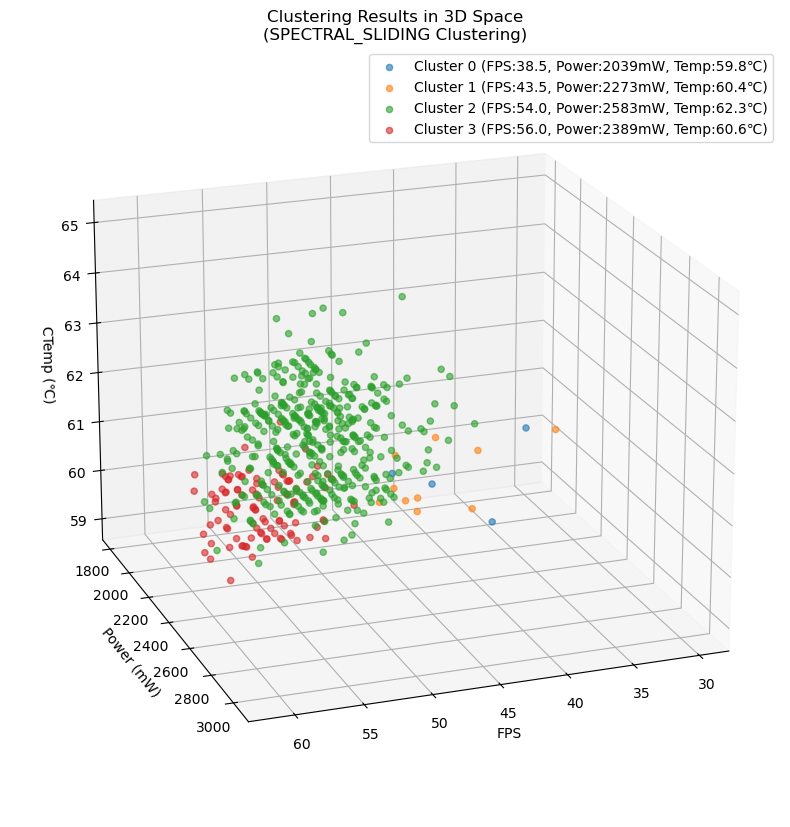

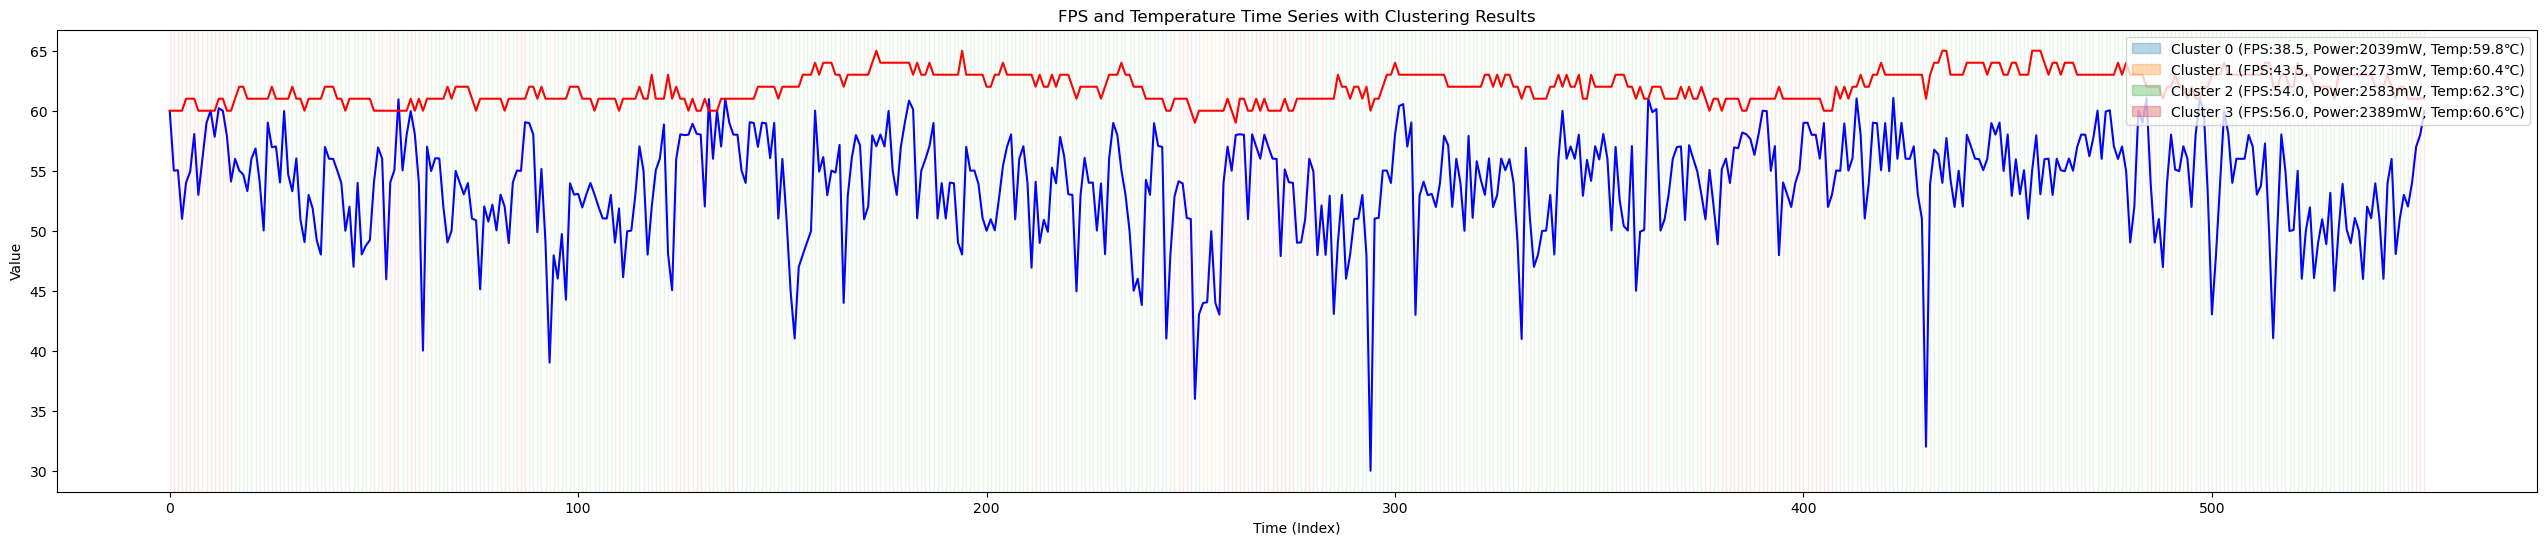

聚类结果统计:
Cluster 0 (FPS:38.5, Power:2039mW, Temp:59.8℃): 4个样本 (0.7%)
Cluster 1 (FPS:43.5, Power:2273mW, Temp:60.4℃): 10个样本 (1.8%)
Cluster 2 (FPS:54.0, Power:2583mW, Temp:62.3℃): 439个样本 (79.4%)
Cluster 3 (FPS:56.0, Power:2389mW, Temp:60.6℃): 100个样本 (18.1%)
未找到标签文件，无法进行SPECTRAL_SLIDING聚类准确率分析

子序列 1 的基本统计:
FPS 范围: 30.00 - 61.06
FPS 平均值: 53.77
功耗范围: 1810 - 3043 mW
功耗平均值: 2538 mW
温度范围: 59 - 65 ℃
温度平均值: 61.9 ℃


In [38]:
import os

test_file="test1.csv"
label_file="test_5.csv"

# Load data
df_test, _ = load_data(test_file)

# Preprocess features
features_scaled, scaler, feature_columns = preprocess_features(df_test)

classifier, loaded_scaler = load_classifier("clustering_model.pkl")

features=['FPS', 'CTemp[℃]', 'Power[mW]']
predicting_feature = df_test[features].values
# Predict using the loaded classifier
predicted_labels = classifier.predict(predicting_feature)

# Find continuous subsequences of class 0
class_0_subsequences = []
current_subsequence = []

for i, label in enumerate(predicted_labels):
    if label == 0:
        current_subsequence.append(i)
    else:
        if len(current_subsequence) > 0:
            class_0_subsequences.append(current_subsequence)
            current_subsequence = []

# Don't forget the last subsequence if it ends with class 0
if len(current_subsequence) > 0:
    class_0_subsequences.append(current_subsequence)

# Filter subsequences with minimum length (optional)
min_length = 60  # Adjust as needed
long_class_0_subsequences = [subseq for subseq in class_0_subsequences if len(subseq) >= min_length]

print(f"Found {len(class_0_subsequences)} continuous class 0 subsequences")
print(f"Found {len(long_class_0_subsequences)} subsequences with length >= {min_length}")

# Extract the actual data for these subsequences
class_0_data_subsequences = []
for subseq in long_class_0_subsequences:
    start_idx = subseq[0]
    end_idx = subseq[-1] + 1
    subsequence_data = df_test.iloc[start_idx:end_idx]
    class_0_data_subsequences.append(subsequence_data)
    print(f"Subsequence: indices {start_idx}-{end_idx-1}, length: {len(subseq)}")

# 

# Analyze each class 0 subsequence
for i, subsequence_data in enumerate(class_0_data_subsequences):
    print(f"\n{'='*60}")
    print(f"分析子序列 {i+1} (索引 {long_class_0_subsequences[i][0]}-{long_class_0_subsequences[i][-1]})")
    print(f"子序列长度: {len(subsequence_data)}")
    print(f"{'='*60}")
    
    # Save subsequence data to temporary CSV for analysis
    temp_csv_path = f"temp_subsequence_{i+1}.csv"
    subsequence_data.to_csv(temp_csv_path, index=False)
    
    try:
        # Perform clustering analysis on this subsequence
        subseq_results = run_clustering_analysis(
            test_file=temp_csv_path,
            label_file=None,  # No labels for subsequences
            clustering_method='spectral_sliding',
            n_clusters=4,
            train_classifier_flag=False,  # Don't train classifier for subsequences
            random_state=42
        )
        
        # Print basic statistics for this subsequence
        print(f"\n子序列 {i+1} 的基本统计:")
        print(f"FPS 范围: {subsequence_data['FPS'].min():.2f} - {subsequence_data['FPS'].max():.2f}")
        print(f"FPS 平均值: {subsequence_data['FPS'].mean():.2f}")
        print(f"功耗范围: {subsequence_data['Power[mW]'].min()} - {subsequence_data['Power[mW]'].max()} mW")
        print(f"功耗平均值: {subsequence_data['Power[mW]'].mean():.0f} mW")
        print(f"温度范围: {subsequence_data['CTemp[℃]'].min()} - {subsequence_data['CTemp[℃]'].max()} ℃")
        print(f"温度平均值: {subsequence_data['CTemp[℃]'].mean():.1f} ℃")
        
    except Exception as e:
        print(f"分析子序列 {i+1} 时出错: {str(e)}")
    
    finally:
        # Clean up temporary file
        if os.path.exists(temp_csv_path):
            os.remove(temp_csv_path)
